In [3]:
import pandas as pd
import numpy as np
from IPython.display import display, Latex
import random
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, ifft, fftfreq


import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ModelWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ModelWarning)
warnings.simplefilter('ignore')


In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [382]:
class myAR:
    def __init__(self, c, phis):
        self.c = c
        self.phis = phis
        self.eps = 0.8
        self.burnIn = 0
        self.order = len(phis)
        self.y = []
        self.y_cut = []
        self.autoCor = None
        self.pAutoCor = None
        self.name = self.getEquationStr()
        
    def predictMany(self, initials, t): 
        self.y = np.zeros(t)
        # set initials
        for i in range(len(initials)):
            self.y[i] = initials[i]
        
        # set the other elements
        for i in np.arange(len(initials), t):
            self.y[i] = self.c
            for idx, phi in enumerate(self.phis):
                self.y[i] += phi * self.y[i-(idx+1)]
            self.y[i] += np.random.normal(0, 1)
            
        # check autocorrelation
        _, ax = plt.subplots(4, figsize = (20,8))
        #ax[0].set_xlabel('time')
        
        timeCorr = 40#(len(self.y) - 1)//10
        self.autoCor = acf(self.y, nlags = timeCorr, fft = True)
        self.pAutoCor = pacf(self.y, nlags= timeCorr)
        
        # determine burnin
        self.burnin()
    
        plot_acf(self.y, ax=ax[1], lags = timeCorr, fft = True, zero = False)
        plot_pacf(self.y, ax=ax[2], lags = timeCorr)

        ax[0].plot(self.y)
        ax[0].set_title(f'Autoregressive model ${self.name}$ with T={len(self.y)} and init={initials}, burnIn={self.burnIn}')
        ax[3].plot(self.y_cut)
        ax[3].set_title(f'Burnin cut')
        
        
        #self.burnin()
    # http://sbfnk.github.io/mfiidd/mcmc_diagnostics.html#33_burn-in
    def tests(self, data):
        # jung - box - whether we are dealing with white noise
        # with hypothesis of stationary ts we look at p_value - close to one - uncorrelated - up to lags
        jung = acorr_ljungbox(data, lags = [40], return_df=True)
        print("\n\t\t->jung_test (p_value close to 1 -> uncorrelated):\n\n", jung)
        
        # augumented Dickey_Fuller test
        # wheather we are dealing with stationary or not
        fuller = adfuller(data) # timeseries in non-stationary
        print("\n\t\t->adfuller (p_value close to 0 -> stationary):\n\n",fuller)
        # if p value is small - > it is stationary
        
        #kwiatkowski-phillips-s.. test - > hyphothesis is that it is stationary -> p_value high -> stationary
        kp = kpss(data)
        print("\n\t\t->kpss (p_value close to 1 -> stationary):\n\n",kp)
        
    def burnin(self):
       
        print("\n\n\t->test before:")
        self.tests(self.y)
        val = np.exp(-1/self.eps)
        for i in np.arange(len(self.autoCor)):
            autocor = abs(self.autoCor[i])    
            if autocor < val:
                self.burnIn = i
                break
        self.y_cut = self.y[self.burnIn:-1]
        print("\n\n\t->test after:")
        self.tests(self.y_cut)
        print(f'\n\t->Burnin parameter is {self.burnIn}')
    
    def getEquationStr(self):
        eq = f'y_t={self.c}'
        inside = str([f'{"+" if val > 0 else ""}{val:.2f}'+'y_{t-%s}'%(str(t+1)) for t, val in enumerate(self.phis)]).replace('\'[]','')
        for k in ['\'', '[', ']']:
            inside = inside.replace(k,'')
        eq += inside
        eq += '+e_t'
        display(Latex(f" --------------------------------- Doing AR({len(self.y)}): ${eq}$ --------------------------------- "))
        return  eq


## first -0.6

<IPython.core.display.Latex object>



	->test before:

		->jung_test (p_value close to 1 -> uncorrelated):

         lb_stat  lb_pvalue
40  3211.230687        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-144.52537996183133, 0.0, 0, 4999, {'1%': -3.431658793968827, '5%': -2.862118345383404, '10%': -2.567077853953267}, 14069.713687391588)

		->kpss (p_value close to 1 -> stationary):

 (0.043108636858788914, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


	->test after:

		->jung_test (p_value close to 1 -> uncorrelated):

        lb_stat  lb_pvalue
40  3211.87973        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-144.45806143359147, 0.0, 0, 4995, {'1%': -3.43165984259144, '5%': -2.8621188086591505, '10%': -2.5670781005730454}, 14061.586368662223)

		->kpss (p_value close to 1 -> stationary):

 (0.04221812642800603, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

	->Burnin parameter is 3


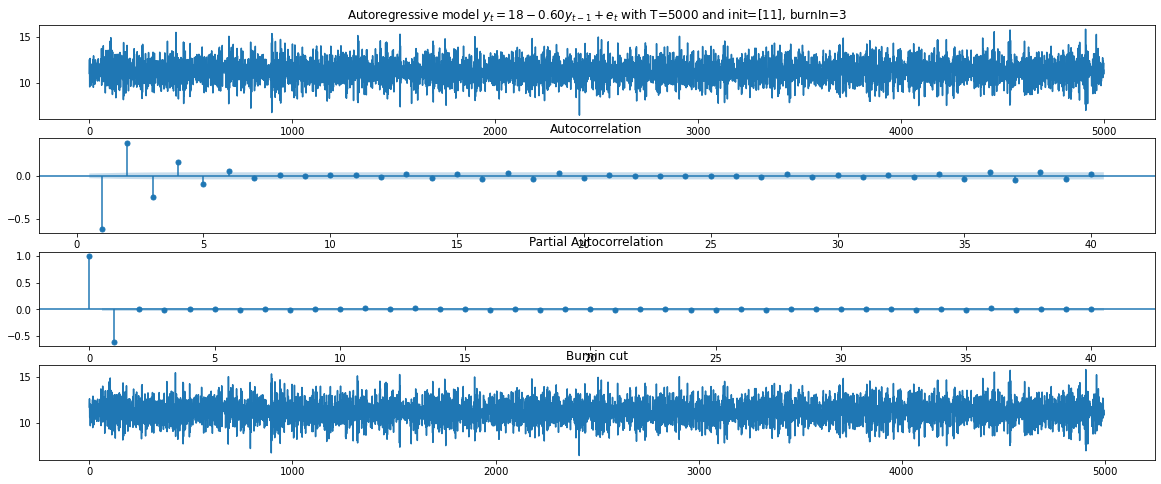

In [383]:

c = 18
phi = [-0.6]
a = myAR(c, phi)
a.predictMany([random.randrange(-c,c)], 5000)


## second -0.7

<IPython.core.display.Latex object>



	->test before:

		->jung_test (p_value close to 1 -> uncorrelated):

         lb_stat  lb_pvalue
40  4824.220559        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-169.149426439133, 0.0, 0, 4999, {'1%': -3.431658793968827, '5%': -2.862118345383404, '10%': -2.567077853953267}, 14015.282534113492)

		->kpss (p_value close to 1 -> stationary):

 (0.10384344131939145, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


	->test after:

		->jung_test (p_value close to 1 -> uncorrelated):

         lb_stat  lb_pvalue
40  4773.241158        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-166.86528207355198, 0.0, 0, 4994, {'1%': -3.4316601050096995, '5%': -2.8621189245940792, '10%': -2.5670781622897416}, 13998.629022657227)

		->kpss (p_value close to 1 -> stationary):

 (0.12432461632629062, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

	->Burnin parameter is 4


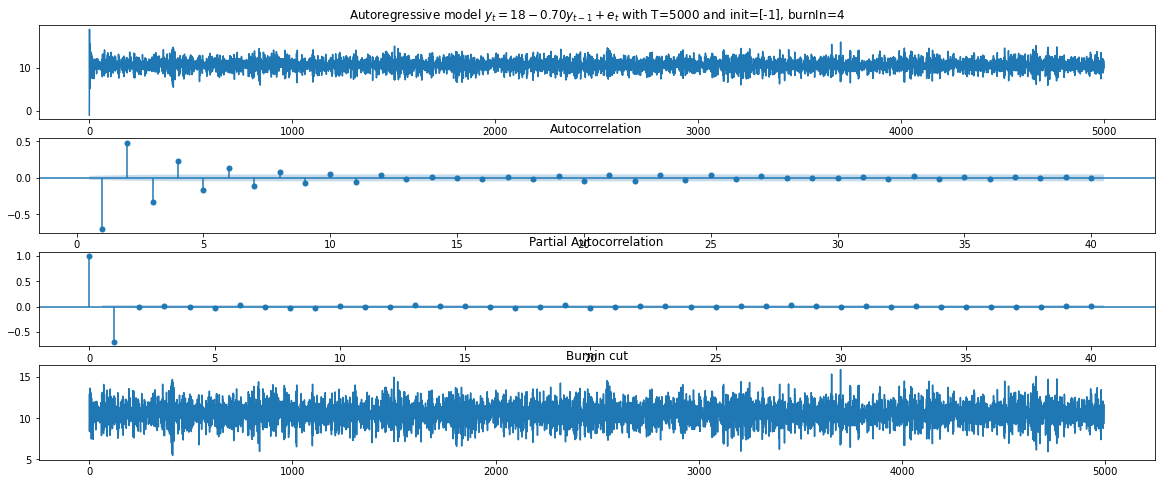

In [384]:

c = 18
phi = [-0.7]

a = myAR(c, phi)
a.predictMany([random.randrange(-c,c)], 5000)


## third -0.8

<IPython.core.display.Latex object>



	->test before:

		->jung_test (p_value close to 1 -> uncorrelated):

          lb_stat  lb_pvalue
40  10267.983847        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-218.14508815394817, 0.0, 0, 4999, {'1%': -3.431658793968827, '5%': -2.862118345383404, '10%': -2.567077853953267}, 14138.656749769565)

		->kpss (p_value close to 1 -> stationary):

 (0.034474461427187235, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


	->test after:

		->jung_test (p_value close to 1 -> uncorrelated):

          lb_stat  lb_pvalue
40  10321.521065        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-216.92445738095412, 0.0, 0, 4991, {'1%': -3.4316608928957413, '5%': -2.862119272677694, '10%': -2.5670783475882715}, 14114.029034710054)

		->kpss (p_value close to 1 -> stationary):

 (0.0364801198278775, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

	->Burnin parameter is 7


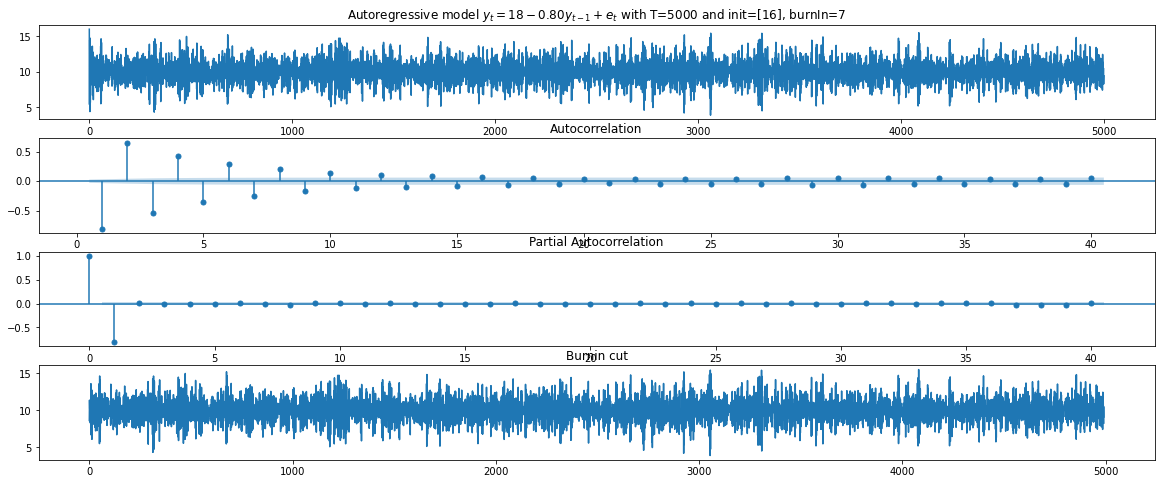

In [385]:
c = 18
phi = [-0.8]


a = myAR(c, phi)
a.predictMany([random.randrange(-c,c)], 5000)

## fourth -0.9

<IPython.core.display.Latex object>



	->test before:

		->jung_test (p_value close to 1 -> uncorrelated):

          lb_stat  lb_pvalue
40  18334.815674        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-299.3606105589463, 0.0, 0, 4999, {'1%': -3.431658793968827, '5%': -2.862118345383404, '10%': -2.567077853953267}, 14002.190328717637)

		->kpss (p_value close to 1 -> stationary):

 (0.04339043699315089, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


	->test after:

		->jung_test (p_value close to 1 -> uncorrelated):

          lb_stat  lb_pvalue
40  18329.607469        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-299.058368252791, 0.0, 0, 4988, {'1%': -3.43166168173001, '5%': -2.8621196211801374, '10%': -2.5670785331097763}, 13975.562157406333)

		->kpss (p_value close to 1 -> stationary):

 (0.051361310735682765, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

	->Burnin parameter is 10


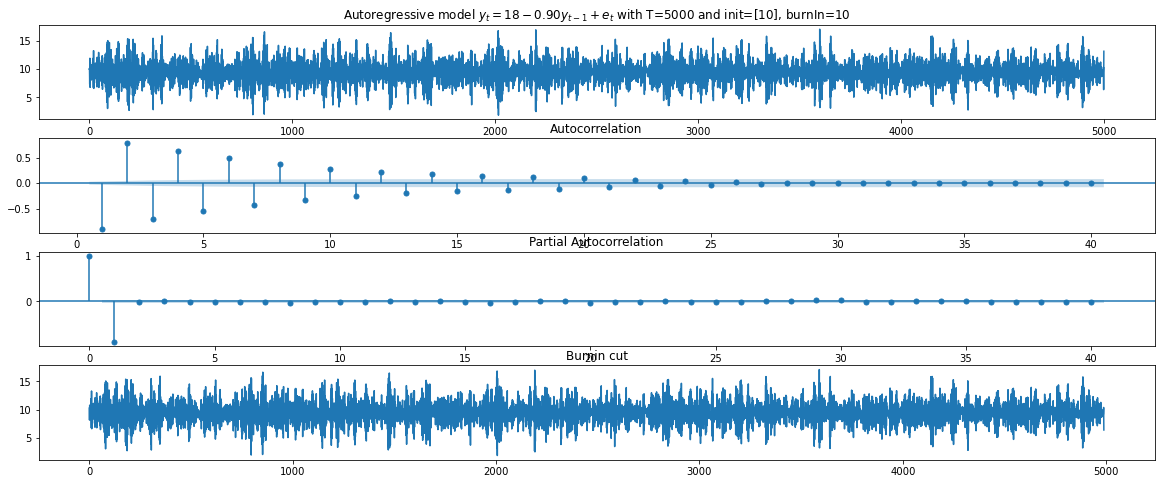

In [386]:

c = 18
phi = [-0.9]
a = myAR(c, phi)
a.predictMany([random.randrange(-c,c)], 5000)


## fifth -1.1

<IPython.core.display.Latex object>



	->test before:

		->jung_test (p_value close to 1 -> uncorrelated):

     lb_stat  lb_pvalue
40      NaN        NaN

		->adfuller (p_value close to 0 -> stationary):

 (nan, nan, 0, 4999, {'1%': -3.431658793968827, '5%': -2.862118345383404, '10%': -2.567077853953267}, inf)

		->kpss (p_value close to 1 -> stationary):

 (nan, nan, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


	->test after:

		->jung_test (p_value close to 1 -> uncorrelated):

     lb_stat  lb_pvalue
40      NaN        NaN

		->adfuller (p_value close to 0 -> stationary):

 (nan, nan, 0, 4998, {'1%': -3.431659055967043, '5%': -2.862118461132801, '10%': -2.5670779155711902}, inf)

		->kpss (p_value close to 1 -> stationary):

 (nan, nan, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

	->Burnin parameter is 0


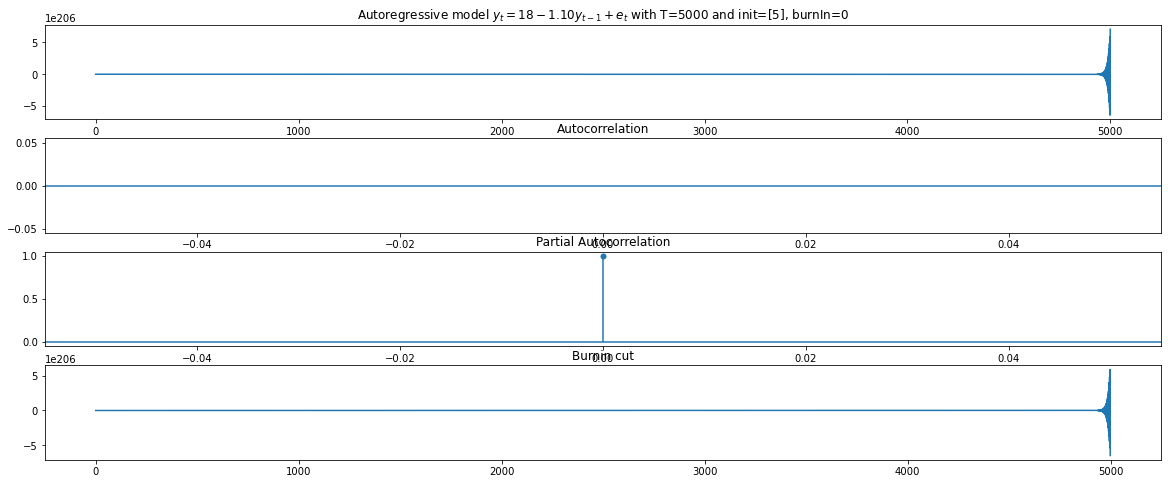

In [387]:


c = 18
phi = [-1.1]
a = myAR(c, phi)
a.predictMany([random.randrange(-c,c)], 5000)


## sixth AR(2) 8, 1.3, -0.7

<IPython.core.display.Latex object>



	->test before:

		->jung_test (p_value close to 1 -> uncorrelated):

         lb_stat  lb_pvalue
40  5804.937023        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-57.42899706589504, 0.0, 1, 4998, {'1%': -3.431659055967043, '5%': -2.862118461132801, '10%': -2.5670779155711902}, 14174.173917762771)

		->kpss (p_value close to 1 -> stationary):

 (0.3853920554235468, 0.0834517002484712, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


	->test after:

		->jung_test (p_value close to 1 -> uncorrelated):

         lb_stat  lb_pvalue
40  5915.465597        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-56.652696987980036, 0.0, 1, 4994, {'1%': -3.4316601050096995, '5%': -2.8621189245940792, '10%': -2.5670781622897416}, 14160.980452961647)

		->kpss (p_value close to 1 -> stationary):

 (0.5743337910545769, 0.024969655358674823, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

	->Burnin parameter is 3


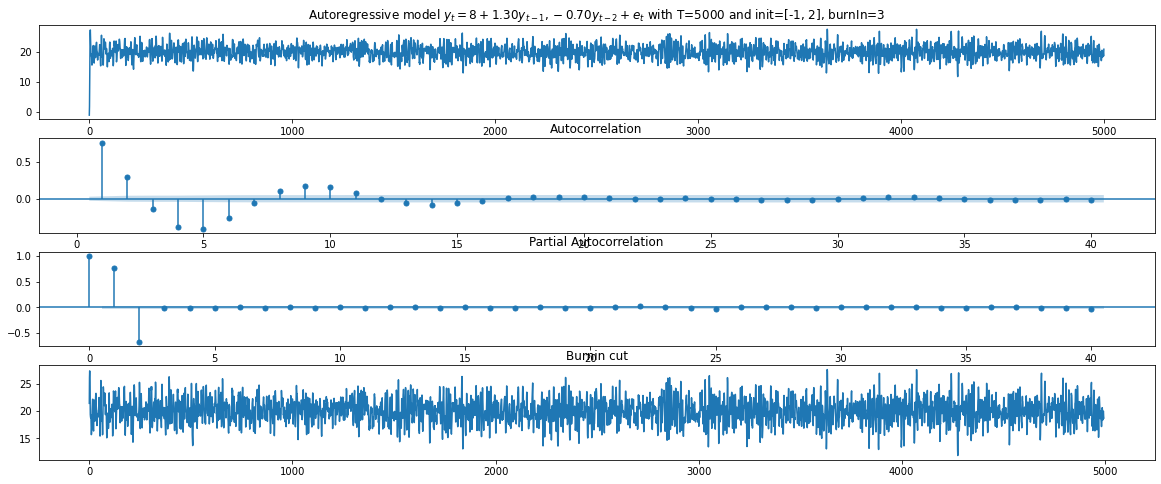

In [388]:
c = 8
phi = [1.3, -0.7]
a = myAR(c, phi)
a.predictMany([random.randrange(-c,c), random.randrange(-c,c)], 5000)

# AR FORECASTING

In [28]:
from statsmodels.tsa.ar_model import AR, ARResults
def printAR(fit):
    print(f'Lag:\n\t{fit.k_ar}\ncoeff:\n{fit.params}')
    
def reverseDiff(df, diff, column, shift = 1):
    x, x_diff = df[column].iloc[0], diff.iloc[shift:]
    return pd.Series(np.r_[x, x_diff].cumsum())

shift = 1
maxlag = 3

In [29]:
robusta = pd.read_html('https://www.indexmundi.com/commodities/?commodity=robusta-coffee&months=240')
robustaDF = robusta[1]
robustaDF['Month'] = pd.to_datetime(robustaDF['Month'])
robustaDF.set_index(['Month'], inplace = True)
start = datetime.datetime(2013,1,1)
end = datetime.datetime(2015,1,1)
mask = (robustaDF.index > start) & (robustaDF.index <= end)
robustaDF = robustaDF.loc[mask]
robustaDF


,Price,Change
Month,,
2013-02-01,2.29,4.09%
2013-03-01,2.34,2.18%
2013-04-01,2.24,-4.27%
2013-05-01,2.19,-2.23%
2013-06-01,2.00,-8.68%
2013-07-01,2.10,5.00%
2013-08-01,2.07,-1.43%
2013-09-01,1.94,-6.28%
2013-10-01,1.85,-4.64%


## Train-Test split

,price from first 21 months,Change
Month,,
2013-02-01,2.29,4.09%
2013-03-01,2.34,2.18%
2013-04-01,2.24,-4.27%
2013-05-01,2.19,-2.23%
2013-06-01,2.00,-8.68%
2013-07-01,2.10,5.00%
2013-08-01,2.07,-1.43%
2013-09-01,1.94,-6.28%
2013-10-01,1.85,-4.64%


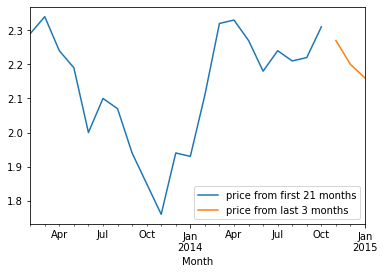

In [30]:
forecastLen = 3
trainLen = len(robustaDF)-forecastLen

trainRobusta = robustaDF.iloc[:trainLen]
testRobusta = robustaDF.iloc[trainLen:]
trainRobusta.columns = [f'price from first {len(robustaDF)-forecastLen} months', 'Change']
testRobusta.columns = [f'price from last {forecastLen} months', 'Change']
ax = trainRobusta.plot()
testRobusta.plot(ax=ax, label = f'last {forecastLen} months', legend = True)


columnTrain = trainRobusta.columns[0]
columnTest = testRobusta.columns[0]
trainRobusta

## Non-differenced data

Lag:
	3
coeff:
const                            0.655231
L1.price from first 21 months    0.932522
L2.price from first 21 months   -0.021478
L3.price from first 21 months   -0.215382
dtype: float64
The accuracy is - mse = 0.0022511415979403994


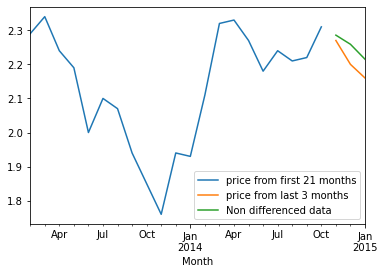

In [31]:
modelNon = AR(trainRobusta[columnTrain])
# fit
fitNon = modelNon.fit(maxlag = maxlag, method = 'mle')
printAR(fitNon)
# predict
start = len(trainRobusta)
end = len(trainRobusta) + len(testRobusta) - 1
predNon = fitNon.predict(start = start, end = end, dynamic = False).rename('Non differenced data')

ax = trainRobusta.plot()
testRobusta.plot(ax=ax)
predNon.plot(ax=ax)
ax.legend()
accNon = mean_squared_error(testRobusta[columnTest].to_numpy(), predNon.to_numpy())
print(f"The accuracy is - mse = {accNon}")

## Differenced data

### check the autocorrelation


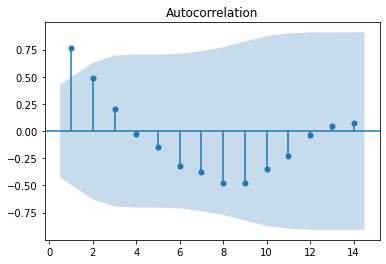

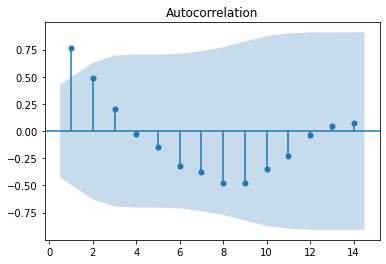

In [27]:
plot_acf(trainRobusta[columnTrain], zero = False)

### create difference

Month
2013-03-01    0.05
2013-04-01   -0.10
2013-05-01   -0.05
2013-06-01   -0.19
2013-07-01    0.10
2013-08-01   -0.03
2013-09-01   -0.13
2013-10-01   -0.09
2013-11-01   -0.09
2013-12-01    0.18
2014-01-01   -0.01
2014-02-01    0.18
2014-03-01    0.21
2014-04-01    0.01
2014-05-01   -0.06
2014-06-01   -0.09
2014-07-01    0.06
2014-08-01   -0.03
2014-09-01    0.01
2014-10-01    0.09
Name: price from first 21 months, dtype: float64

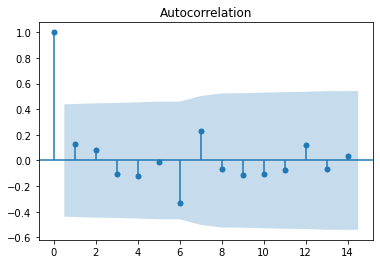

In [32]:
trainRobustaDiff = trainRobusta[columnTrain].diff(shift).dropna()
plot_acf(trainRobustaDiff)
trainRobustaDiff

### fit again

In [33]:
model = AR(trainRobustaDiff.to_numpy())
# fit
fit = model.fit(maxlag = maxlag, method = 'mle')
printAR(fit)
# predict
start = len(trainRobustaDiff) #+ diff
end = len(trainRobustaDiff) + len(testRobusta) - 1
pred = fit.predict(start = start, end = end, dynamic = False)
pred = pd.Series(pred, index = testRobusta.index)

fullDifferencedPred = trainRobusta[columnTrain].diff(shift).append(pred, ignore_index=True)
# return to non-differenced data
diffBack = reverseDiff(trainRobusta, trainRobusta[columnTrain].diff(shift), columnTrain, shift)
predReal = reverseDiff(trainRobusta, fullDifferencedPred, columnTrain, shift)

full = pd.DataFrame(columns=['real','diff', 'back'])
full['diff'] = trainRobustaDiff
full['real'] = trainRobusta[columnTrain].iloc[shift:]
full['back'] = diffBack.iloc[shift:].to_numpy()

#"print(predReal)
predReal = pd.Series(predReal[shift:].to_numpy(), index = robustaDF.index[1:])
predRealTest = pd.DataFrame(columns=['pred','real'])
predRealTest['differenced'] = predReal.to_numpy()
predRealTest['real'] = robustaDF['Price'].iloc[shift:].to_numpy()
predRealTest.index = robustaDF.index[shift:]
predRealTest 


Lag:
	3
coeff:
[ 0.00223507  0.13139676  0.08000348 -0.12305034]


,pred,real,differenced
Month,,,
2013-03-01,NaN,2.34,2.340000
2013-04-01,NaN,2.24,2.240000
2013-05-01,NaN,2.19,2.190000
2013-06-01,NaN,2.00,2.000000
2013-07-01,NaN,2.10,2.100000
2013-08-01,NaN,2.07,2.070000
2013-09-01,NaN,1.94,1.940000
2013-10-01,NaN,1.85,1.850000
2013-11-01,NaN,1.76,1.760000


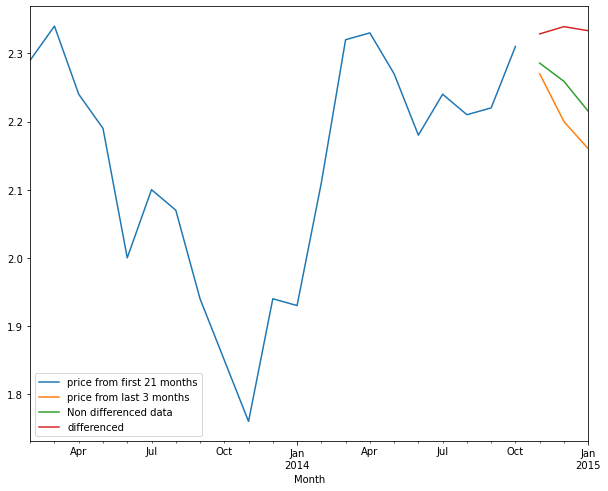

The accuracy is - mse = 0.0022511415979403994


In [34]:

# compare all predictions
fig, ax = plt.subplots(1, figsize = (10,8))
# plot just the training
trainRobusta[columnTrain].plot(ax = ax)
# plot real data from last part
testRobusta[columnTest].plot(ax = ax)
#ax.plot(testRobusta.index, np.array(testRobusta[columnTest]), label = 'original data')
# plot non-differenced prediction
predNon.plot(ax=ax)
# plot differenced prediction
#ax.plot(testRobusta.index, predNon.diff(), label = 'non-differenced data predicted')
predRealTest.iloc[trainLen-shift:]['differenced'].plot(ax=ax)
#ax.plot(testRobusta.index, pred, label = 'differenced data predicted')
ax.legend()
plt.show()

#accNon = mean_squared_error(testRobusta[columnTest].diff().to_numpy(), predNon.to_numpy())
print(f"The accuracy is - mse = {accNon}")
#testRobusta.index, pred